In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
from typing import Dict
import warnings
warnings.filterwarnings('ignore')
import copy
from tqdm import tqdm
import random
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from stformer import logger
from stformer.tokenizer import GeneVocab
from stformer.tokenizer import tokenize_and_pad_batch
from stformer.model import TransformerModel

In [2]:
class SlideData():
    def __init__(self, data_path, slide, vocab, pad_value, pad_token):
        self.data_path = data_path
        self.slide = slide
        self.vocab = vocab
        self.pad_value = pad_value
        self.pad_token = pad_token
        self.load_data()
    
    def load_data(self):
        adata = sc.read_h5ad(f'{self.data_path}/{self.slide}_Visium_deconv.h5ad')

        scfoundation_gene_df = pd.read_csv(f'{tokenizer_dir}/scfoundation_gene_df.csv')
        scfoundation_gene_df.set_index('gene_ids', inplace=True)
        total_gene_num = adata.shape[1]
        adata = adata[:, adata.var_names.isin(scfoundation_gene_df.index)]
        adata.var['gene_name'] = scfoundation_gene_df.loc[adata.var_names, 'gene_symbols'].values
        seleted_gene_num = adata.shape[1]
        genes = adata.var["gene_name"].tolist()
        gene_ids = np.array(self.vocab(genes), dtype=int)

        logger.info(
            f"match {seleted_gene_num}/{total_gene_num} genes "
            f"in vocabulary of size 19264."
        )

        ligand_database = pd.read_csv(tokenizer_dir+'ligand_database.csv', header=0, index_col=0)
        ligand_symbol = ligand_database[ligand_database.sum(1)>1].index.values
        ligand_ids = self.vocab(ligand_symbol.tolist())
        adata = adata[(adata[:,adata.var['gene_name'].isin(ligand_symbol)].X.sum(1)>0).A.T[0],:]
            
        celltype_proportion = adata.obsm['q05_cell_abundance_w_sf']
        celltype_proportion.rename(columns=lambda x: x[23:], inplace=True)
        celltype_proportion = celltype_proportion.div(celltype_proportion.sum(axis=1), axis=0)
        celltype_proportion[celltype_proportion < 0.05] = 0
        celltype_proportion = celltype_proportion.div(celltype_proportion.sum(axis=1), axis=0)

        for celltype in adata.layers.keys():
            adata.X = adata.layers[celltype]
            sc.pp.normalize_total(adata, target_sum=1e4)
            sc.pp.log1p(adata)
            adata.uns.pop('log1p')
            adata.layers[celltype] = adata.X

        self.adata = adata
        self.celltype_proportion = celltype_proportion
        self.gene_ids = gene_ids
        self.ligand_ids = ligand_ids

    def get_niche_samples(self, del_celltype=None, pert_ligand=None, pert_receptor=None, pert_value=0):
        samples_expression = []
        samples_ctprop = []
        celltypes_labels = []
        samples_niche = []

        for i in range(self.adata.shape[0]):
            ct_prop = self.celltype_proportion.iloc[i][self.celltype_proportion.iloc[i]>0]
            
            if del_celltype is not None and pert_ligand is None:
                ct_prop.drop(set(del_celltype).intersection(set(ct_prop.index)), inplace=True)

            niche_counts = [self.adata.layers[ct][i].A for ct in ct_prop.index]
            if len(niche_counts) == 0:
                niche_counts = np.empty([0, self.adata.shape[1]])
            else:
                niche_counts = np.concatenate(niche_counts)
                niche_counts[:,~np.isin(self.gene_ids, self.ligand_ids)] = 0
            niche_ctprop = ct_prop.values
            niche_ct = ct_prop.index.values

            if pert_ligand is not None:
                for ligand_gene in pert_ligand:
                    if del_celltype is not None:
                        for del_ct in del_celltype:
                            if niche_counts[np.where(ct_prop.index==del_ct)[0][0], np.where(self.gene_ids==self.vocab[ligand_gene])[0][0]] > 0:
                                niche_counts[np.where(ct_prop.index==del_ct)[0][0], np.where(self.gene_ids==self.vocab[ligand_gene])[0][0]] = pert_value
                    else:
                        nonzero_index = np.nonzero(niche_counts[:, np.where(self.gene_ids==self.vocab[ligand_gene])[0][0]])[0]
                        niche_counts[nonzero_index, np.where(self.gene_ids==self.vocab[ligand_gene])[0][0]] = pert_value

            ct_prop = self.celltype_proportion.iloc[i][self.celltype_proportion.iloc[i]>0]
            for ct in ct_prop.index:
                counts = self.adata.layers[ct][i].A
                if pert_receptor is not None:
                    for receptor_gene in pert_receptor:
                        if counts[0, np.where(self.gene_ids==self.vocab[receptor_gene])[0][0]] > 0:
                            counts[0, np.where(self.gene_ids==self.vocab[receptor_gene])[0][0]] = pert_value
                samples_expression.append(np.concatenate([counts, niche_counts],axis=0))
                samples_ctprop.append(niche_ctprop)
                samples_niche.append(niche_ct)
                celltypes_labels.append(ct)

        self.expression = samples_expression
        self.ctprop = samples_ctprop
        self.celltypes = celltypes_labels
        self.niche = samples_niche

    def tokenize_data(self):

        max_seq_len = np.max(np.count_nonzero(self.adata.X.A, axis=1))+2
        max_niche_cell_num = (self.celltype_proportion>0).sum(1).max()
        self.max_seq_len = max_seq_len
        self.max_niche_cell_num = max_niche_cell_num

        tokenized_data = tokenize_and_pad_batch(
            self.expression,
            self.ctprop,
            self.gene_ids,
            max_len = max_seq_len,
            max_niche_cell_num = max_niche_cell_num,
            vocab = self.vocab,
            pad_token = self.pad_token,
            pad_value = self.pad_value,
            append_cls = False,  # append <cls> token at the beginning
            include_zero_gene = False,
        )
        
        logger.info(
            f"number of samples: {tokenized_data['center_genes'].shape[0]}, "
            f"\n\t feature length of center cell: {tokenized_data['center_genes'].shape[1]}"
            f"\n\t feature length of niche cells: {tokenized_data['niche_genes'].shape[1]}"
        )

        self.tokenized_data = tokenized_data

    def prepare_data(self):
        data_pt = {
            "center_gene_ids": self.tokenized_data["center_genes"],
            "input_center_values": self.tokenized_data["center_values"],
            "target_center_values": self.tokenized_data["center_values"],
            "niche_gene_ids": self.tokenized_data["niche_genes"],
            "input_niche_values": self.tokenized_data["niche_values"],
            "niche_feature_lens": self.tokenized_data["niche_feature_lens"],
            "cross_attn_bias": self.tokenized_data["cross_attn_bias"],
            "celltype_labels": self.celltypes,
        }

        return data_pt

In [3]:
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["center_gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    if num_workers == 0:
        num_workers = min(len(os.sched_getaffinity(0)), batch_size // 2)

    dataset = SeqDataset(data_pt)

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

In [4]:
def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    cell_types_list = []
    gene_embeddings_list = []
    cell_embeddings_list = []
    selected_center_gene_ids = []

    batch_num = 0
    with torch.no_grad():
        for batch_data in tqdm(loader):
            # batch_num += 1
            # if batch_num>100:
            #     break
            niche_feature_lens = batch_data["niche_feature_lens"].to(device)
            if niche_feature_lens.size(0)<12:
                continue
            center_gene_ids = batch_data["center_gene_ids"].to(device)
            input_center_values = batch_data["input_center_values"].to(device)
            niche_gene_ids = batch_data["niche_gene_ids"].to(device)
            input_niche_values = batch_data["input_niche_values"].to(device)
            cross_attn_bias = batch_data["cross_attn_bias"].to(device)
            cell_types_list.append(batch_data["celltype_labels"])

            encoder_src_key_padding_mask = niche_gene_ids.eq(vocab[pad_token])
            decoder_src_key_padding_mask = center_gene_ids.eq(vocab[pad_token])

            with torch.cuda.amp.autocast(enabled=amp):
                output_dict = model(
                        niche_gene_ids,
                        input_niche_values,
                        encoder_src_key_padding_mask,
                        center_gene_ids,
                        input_center_values,
                        decoder_src_key_padding_mask,
                        cross_attn_bias,
                        output_gene_emb = True,
                    )
                cell_embeddings_list.append(output_dict["cell_emb"].to('cpu'))
                # gene_embeddings_list.append(output_dict["gene_emb"].to('cpu'))
                if_selected = torch.isin(center_gene_ids, torch.tensor(selected_gene_ids, device=device))
                gene_embeddings_list.append(output_dict["gene_emb"][if_selected].to('cpu'))
                selected_center_gene_ids.append(center_gene_ids[if_selected].to('cpu'))

    cell_types = np.concatenate(cell_types_list)
    cell_embeddings = torch.cat(cell_embeddings_list)
    gene_embeddings = torch.cat(gene_embeddings_list)
    selected_center_gene_ids = torch.cat(selected_center_gene_ids)

    return gene_embeddings, cell_embeddings, cell_types, selected_center_gene_ids

In [6]:
embsize = 768 #256
d_hid = 3072 #1024
nhead = 12 #4
nlayers = 6 #12
dropout = 0.1
cell_emb_style = 'max-pool' #"cls"

In [ ]:
from scfoundation import load
pretrainmodel, pretrainconfig = load.load_model_frommmf('scfoundation/models/models.ckpt')

model = TransformerModel(
        embsize,
        nhead,
        d_hid,
        nlayers,
        dropout = dropout,
        cell_emb_style = cell_emb_style,
        scfoundation_token_emb1 = copy.deepcopy(pretrainmodel.token_emb),
        scfoundation_token_emb2 = copy.deepcopy(pretrainmodel.token_emb),
        scfoundation_pos_emb1 = copy.deepcopy(pretrainmodel.pos_emb),
        scfoundation_pos_emb2 = copy.deepcopy(pretrainmodel.pos_emb),
    )

model_file = '../pretraining/model.ckpt'
pt_model = torch.load(model_file, map_location='cpu')

model_dict = model.state_dict()
pretrained_dict = pt_model.state_dict()
pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if 'cls_decoder' not in k and 'gcl_decoder' not in k
            # if k in model_dict and v.shape == model_dict[k].shape
}
# for k, v in pretrained_dict.items():
#     logger.info(f"Loading params {k} with shape {v.shape}")
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

pre_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())
for name, para in model.named_parameters():
    para.requires_grad = False
logger.info(f"Total Pre freeze Params {(pre_freeze_param_count )}")

In [11]:
model = nn.DataParallel(model, device_ids = [2, 1, 0, 3])

device = torch.device("cuda:2")
model.to(device)

DataParallel(
  (module): TransformerModel(
    (scfoundation_token_emb1): AutoDiscretizationEmbedding2(
      (mlp): Linear(in_features=1, out_features=100, bias=True)
      (mlp2): Linear(in_features=100, out_features=100, bias=True)
      (LeakyReLU): LeakyReLU(negative_slope=0.1)
      (Softmax): Softmax(dim=-1)
      (emb): Embedding(100, 768)
      (emb_mask): Embedding(1, 768)
      (emb_pad): Embedding(1, 768)
    )
    (scfoundation_token_emb2): AutoDiscretizationEmbedding2(
      (mlp): Linear(in_features=1, out_features=100, bias=True)
      (mlp2): Linear(in_features=100, out_features=100, bias=True)
      (LeakyReLU): LeakyReLU(negative_slope=0.1)
      (Softmax): Softmax(dim=-1)
      (emb): Embedding(100, 768)
      (emb_mask): Embedding(1, 768)
      (emb_pad): Embedding(1, 768)
    )
    (scfoundation_pos_emb1): Embedding(19267, 768)
    (scfoundation_pos_emb2): Embedding(19267, 768)
    (transformer_decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-

In [ ]:
pad_token = "<pad>"
pad_value = 103

tokenizer_dir = '../stformer/tokenizer/'
vocab_file = tokenizer_dir + "scfoundation_gene_vocab.json"
vocab = GeneVocab.from_file(vocab_file)
vocab.append_token(pad_token)
vocab.set_default_index(vocab[pad_token])

amp = True
batch_size = 40

In [ ]:
dataset = 'human_myocardial_infarction_dataset'
data_path = f'../data/{dataset}/'
slide = 'ACH0014'

slideData = SlideData(data_path, slide, vocab, pad_value, pad_token)

print("ligand genes:", [g for g in slideData.adata.var['gene_name'].values if 'WNT' in g])
print("receptor genes:", [g for g in slideData.adata.var['gene_name'].values if 'FZD' in g])
print("lowest expression:", np.min(slideData.adata.X.data))
print("highest expression:", np.max(slideData.adata.X.data))

In [ ]:
del_celltype = None
pert_ligand = ['WNT5B']
pert_receptor =  ['FZD4', 'FZD5', 'FZD6']
pert_value = 0.0004 # 8

In [32]:
target_path = 'gene_lists/n1_target_gene_labels.csv'
df_target = pd.read_csv(target_path, index_col=0)
notch1_targets = df_target.loc[df_target['label']==0,'gene_ids']
notch1_targets = set(notch1_targets).intersection(slideData.adata.var_names)
notch1_targets = set(slideData.adata.var.loc[list(notch1_targets), 'gene_name'])

target_path = 'gene_lists/WNT_direct_targets_vs_housekeeping.csv'
df_target = pd.read_csv(target_path, index_col=0)
wnt_targets = df_target.loc[df_target['Class']=='wnt_direct_target','gene_symbols']
wnt_targets = set(wnt_targets).intersection(slideData.adata.var['gene_name'])
housekeeping = df_target.loc[df_target['Class']=='housekeeping','gene_symbols']
housekeeping = set(housekeeping).intersection(slideData.adata.var['gene_name'])

selected_gene_ids = slideData.vocab(list(notch1_targets.union(wnt_targets).union(housekeeping)))

def generate_gene_embeddings(model, slideData, del_celltype, pert_ligand, pert_receptor, pert_value):
    slideData.get_niche_samples(del_celltype, pert_ligand, pert_receptor, pert_value)
    slideData.tokenize_data()
    data_pt = slideData.prepare_data()
    data_loader = prepare_dataloader(data_pt, batch_size, shuffle=False, drop_last=False)
    gene_embeddings, cell_embeddings, cell_types, selected_center_gene_ids = evaluate(model, data_loader)
    return gene_embeddings, cell_embeddings, cell_types, selected_center_gene_ids, data_pt

spFormer - INFO - match 9165/9827 genes in vocabulary of size 19264.
spFormer - INFO - number of samples: 17929, 
	 feature length of center cell: 4182
	 feature length of niche cells: 1323


100%|██████████| 449/449 [03:00<00:00,  2.49it/s]


In [ ]:
print("No ligand or receptor perturbed")
gene_embeddings_0, cell_embeddings_0, cell_types_0, selected_center_gene_ids_0, data_pt_0 = generate_gene_embeddings(model, slideData, None, None, None, pert_value)

print("Ligands perturbed")
gene_embeddings_ligand, _, _, _, _ = generate_gene_embeddings(model, slideData, None, pert_ligand, None, pert_value)

print("Receptors perturbed")
gene_embeddings_receptor, _, _, _, _ = generate_gene_embeddings(model, slideData, None, None, pert_receptor, pert_value)

print("Both ligands and receptors perturbed")
gene_embeddings_both, _, _, _, _ = generate_gene_embeddings(model, slideData, None, pert_ligand, pert_receptor, pert_value)

In [34]:
### 分别计算具有给定受体基因、给定配体基因的样本索引
receptor_cell_index = np.where(torch.isin(data_pt_0['center_gene_ids'],torch.tensor(slideData.vocab(pert_receptor))).sum(1)>1)[0]
ligand_cell_index = np.where(torch.isin(data_pt_0['niche_gene_ids'],torch.tensor(slideData.vocab(pert_ligand))).sum(1)-1*(data_pt_0['niche_feature_lens']>0).sum(1)>=0)[0]

In [35]:
# target_cell_index = np.where(cell_types_0=='Cardiomyocyte')[0]
cell_index = list(set(receptor_cell_index).intersection(set(ligand_cell_index)))#.intersection(set(target_cell_index)))
print(len(cell_index))

gene_index=[]
for i in range(cell_embeddings_0.shape[0]):
    if i not in cell_index:
        gene_index += [False]*(torch.isin(data_pt_0['center_gene_ids'][i], torch.tensor(selected_gene_ids)).sum().item())
    else:
        gene_index += [True]*(torch.isin(data_pt_0['center_gene_ids'][i], torch.tensor(selected_gene_ids)).sum().item())

gene_index = torch.tensor(gene_index)

59


In [82]:
### 计算敲除给定受体和配体基因前后，target基因和housekeeping基因的 gene embedding 相关性

def compute_pcc(gene_embeddings, target_genes, gene_index):
    pcc = {}
    for gene in target_genes:
        pcc[gene] = []
        gene_index_1 = torch.logical_and(selected_center_gene_ids_0==slideData.vocab[gene], gene_index)
        ge0 = gene_embeddings_0[gene_index_1]
        ge1 = gene_embeddings[gene_index_1]
        for i in range(ge0.shape[0]):
            pcc[gene].append(np.corrcoef(ge0[i], ge1[i])[0,1])
    return pcc

random.seed(1)
n1_targets = random.sample(sorted(notch1_targets), 30)

print("Computing pcc for ligand perturbation")
pcc_wnt_ligand = compute_pcc(gene_embeddings_ligand, wnt_targets, gene_index)
pcc_notch1_ligand = compute_pcc(gene_embeddings_ligand, n1_targets, gene_index)
pcc_hk_ligand = compute_pcc(gene_embeddings_ligand, housekeeping, gene_index)

print("Computing pcc for receptor perturbation")
pcc_wnt_receptor = compute_pcc(gene_embeddings_receptor, wnt_targets, gene_index)
pcc_notch1_receptor = compute_pcc(gene_embeddings_receptor, n1_targets, gene_index)
pcc_hk_receptor = compute_pcc(gene_embeddings_receptor, housekeeping, gene_index)

print("Computing pcc for both ligand and receptor perturbation")
pcc_wnt_both = compute_pcc(gene_embeddings_both, wnt_targets, gene_index)
pcc_notch1_both = compute_pcc(gene_embeddings_both, n1_targets, gene_index)
pcc_hk_both = compute_pcc(gene_embeddings_both, housekeeping, gene_index)

In [ ]:
# print('wnt_targets:')
# for gene in pcc_tg:
#     print(gene, np.median(pcc_wnt[gene]))

# print('notch1_targets:')
# for gene in pcc_non_target:
#     print(gene, np.median(pcc_notch1[gene]))

# print('housekeeping:')
# for gene in pcc_hk:
#     print(gene, np.median(pcc_hk[gene]))

data_wnt_ligand = [k for d in list(pcc_wnt_ligand.values()) for k in d]
data_notch1_ligand = [k for d in list(pcc_notch1_ligand.values()) for k in d]
data_hk_ligand = [k for d in list(pcc_hk_ligand.values()) for k in d]

data_wnt_receptor = [k for d in list(pcc_wnt_receptor.values()) for k in d]
data_notch1_receptor = [k for d in list(pcc_notch1_receptor.values()) for k in d]
data_hk_receptor = [k for d in list(pcc_hk_receptor.values()) for k in d]

data_wnt_both = [k for d in list(pcc_wnt_both.values()) for k in d]
data_notch1_both = [k for d in list(pcc_notch1_both.values()) for k in d]
data_hk_both = [k for d in list(pcc_hk_both.values()) for k in d]

print("ligand perturbation")
print('wnt_targets:', np.median(data_wnt_ligand))
print('notch1_targets:', np.median(data_notch1_ligand))
print('housekeeping:', np.median(data_hk_ligand))

print("receptor perturbation")
print('wnt_targets:', np.median(data_wnt_receptor))
print('notch1_targets:', np.median(data_notch1_receptor))
print('housekeeping:', np.median(data_hk_receptor))

print("both ligand and receptor perturbation")
print('wnt_targets:', np.median(data_wnt_both))
print('notch1_targets:', np.median(data_notch1_both))
print('housekeeping:', np.median(data_hk_both))

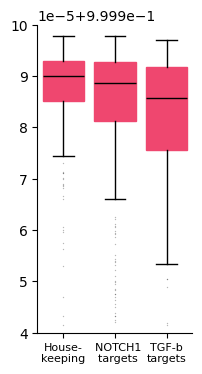

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2, 4))
data = {'hk': data_hk_both, 'tg0': data_notch1_both, 'tg': data_wnt_both}
# Plotting the boxplot
f = plt.boxplot(list(data.values()), widths=0.8, patch_artist=True, medianprops={'color':'black'}, flierprops={'marker': '+', 'markersize':0.1})

for box in f['boxes']:  # 对箱线图设置颜色
    box.set(color='#ef476f', linewidth=1)
plt.ylim(0.99994, 1) # 0.9985 0.94

xticks=[1,2,3]
xtick_labels=['House-\nkeeping', '  NOTCH1\n  targets', 'WNT\ntargets']
plt.xticks(xticks, xtick_labels, fontsize=8)

ax = plt.gca()  # get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('figures/WNT_downreg_both.pdf', bbox_inches='tight')

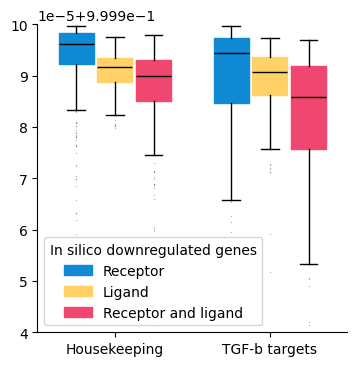

In [48]:
plt.figure(figsize=(4, 4))
data = {'hk_r':data_hk_receptor, 'hk_l':data_hk_ligand, 'hk_both':data_hk_both, 'tg_r':data_wnt_receptor, 'tg_l':data_wnt_ligand, 'tg_both':data_wnt_both}
f = plt.boxplot(list(data.values()), positions=[1,1.5,2,3,3.5,4], medianprops={'color':'black'}, patch_artist=True, flierprops={'marker': '+', 'markersize':0.1})

c_list = ['#118AD5', '#ffd166', '#ef476f', '#118AD5', '#ffd166', '#ef476f']
for box, c in zip(f['boxes'], c_list):  # 对箱线图设置颜色
    box.set(color=c, linewidth=1)
plt.ylim(0.99994, 1) # 0.94 0.9985

xticks=[1.5,3.5]
xtick_labels=['Housekeeping', 'WNT targets']
plt.xticks(xticks, xtick_labels, fontsize=10)

import matplotlib.patches as mpatches
patch1 = mpatches.Patch(color='#118AD5', label='Receptor')
patch2 = mpatches.Patch(color='#ffd166', label='Ligand')
patch3 = mpatches.Patch(color='#ef476f', label='Receptor and Ligand')
plt.legend(title='In silico downregulated genes', handles=[patch1, patch2, patch3], loc='lower left', labels=['Receptor', 'Ligand', 'Receptor and ligand'], fontsize=10)

ax = plt.gca()  # get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('figures/WNT_downreg_either.pdf', bbox_inches='tight')

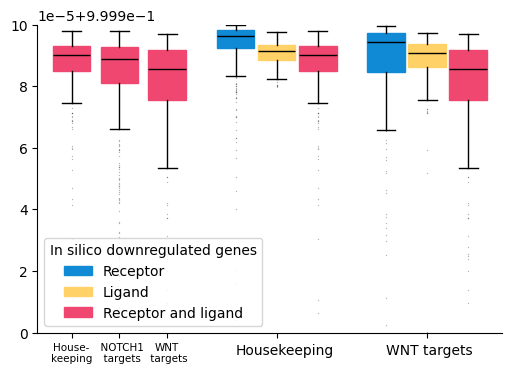

In [50]:
plt.figure(figsize=(6, 4))

# title = 'Effect of in silico upregulation of TGF-b ligands and receptors on gene embeddings'
# plt.title(title, fontsize=10)

data = {'hk':data_hk_both, 'tg0': data_notch1_both, 'tg': data_wnt_both, 'hk_r':data_hk_receptor, 'hk_l':data_hk_ligand, 'hk_both':data_hk_both, 'tg_r':data_wnt_receptor, 'tg_l':data_wnt_ligand, 'tg_both':data_wnt_both}
f = plt.boxplot(list(data.values()), widths=0.55, positions=[1, 1.7, 2.4, 3.4, 4, 4.6, 5.6, 6.2, 6.8], medianprops={'color':'black'}, patch_artist=True, flierprops={'marker': '+', 'markersize':0.1})

c_list = ['#ef476f', '#ef476f', '#ef476f', '#118AD5', '#ffd166', '#ef476f', '#118AD5', '#ffd166', '#ef476f']
for box, c in zip(f['boxes'], c_list):  # 对箱线图设置颜色
    box.set(color=c, linewidth=1)

plt.ylim(0.9999, 1) # 0.9985 0.94

xticks=[1, 1.7, 2.4, 4, 6.2]
xtick_labels=['House-\nkeeping', '  NOTCH1\n  targets', 'WNT\n targets', '', '']
plt.xticks(xticks, xtick_labels, fontsize=7.5)
ax = plt.gca()  # get current axes
ax.text(3.4, 0.999893, 'Housekeeping', fontsize=10)  # 0.9984
ax.text(5.6, 0.999893, 'WNT targets', fontsize=10)  # 0.9984

# ax.text(2.32, 0.9990, '*', fontsize=15)

import matplotlib.patches as mpatches
patch1 = mpatches.Patch(color='#118AD5', label='Receptor')
patch2 = mpatches.Patch(color='#ffd166', label='Ligand')
patch3 = mpatches.Patch(color='#ef476f', label='Receptor and Ligand')
plt.legend(title='In silico downregulated genes', handles=[patch1, patch2, patch3], loc='lower left', labels=['Receptor', 'Ligand', 'Receptor and ligand'], fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('figures/WNT_downreg.pdf', bbox_inches='tight')

In [ ]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

# down both-hk 2.726657676517769e-07, 5.45331535e-07
# down both-n1  0.0013959339176337212, 1.67512070e-03
# down receptor-hk 1.5671643332686585e-05, 2.35074650e-05
# down ligand-hk 0.004054519357042179, 4.05451936e-03
# down both-receptor  2.393318899183068e-13, 1.43599134e-12
# down both-ligand  1.9082794324694444e-09, 5.72483830e-09

both_hk = ranksums(data_wnt_both, data_hk_both, alternative='less')
both_n1 = ranksums(data_wnt_both, data_notch1_both, alternative='less')
receptor_hk = ranksums(data_wnt_receptor, data_hk_receptor, alternative='less')
ligand_hk = ranksums(data_wnt_ligand, data_hk_ligand, alternative='less')
both_receptor = ranksums(data_wnt_both, data_wnt_receptor, alternative='less')
both_ligand = ranksums(data_wnt_both, data_wnt_ligand, alternative='less')

p_values = [both_hk.pvalue, both_n1.pvalue, receptor_hk.pvalue, ligand_hk.pvalue, both_receptor.pvalue, both_ligand.pvalue]
print("p-values:", p_values)

_, p_values_fdr, _, _ = multipletests(p_values, method='fdr_bh')
print("FDR-corrected p-values:", p_values_fdr)